In [20]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from datetime import date, datetime
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import seaborn as sns

# Cargamos las variables de entorno
load_dotenv()

# Lista de columnas
lst_col = [
    "dr0",
    "dr7",
    "dr15",
    "dr30",
    "dr60",
    "dr90",
    "dr180",
    "dr",
    #"yield"
]

# ANALISIS EXPLORATORIO DEL MODELO DE FRAUDE
## Funciones

Las variables escogidas para realziar las primeras pruebas son las siguientes

- bank_name 
- Amount
- Days
- Promo_code_id
- ip_asn_flag 
- ip_city_flag
- data_breaches
- is_apple_relay
- digital_presence_score
- num_profesional_network_tools
- good_behavioral_apps
- is_nie

In [21]:
#########################################################################################################################################################
################################################################ FUNCIONES ##############################################################################
#########################################################################################################################################################

def shrinkage(df, var, dr='dr90'):

    # Calculamos la cantidad de datos de cada uno de las categorias de var
    df_count = df[var].value_counts().reset_index()

    # Media global de DR
    global_dr = df[dr].mean()

    # Calculamos la media de cada uno de los subgrupos
    df_mean = df.groupby(var)[dr].mean().reset_index()

    # Combinamos los dos df donde tenemos la media de cada uno de los bancos
    df_mean = df_mean.merge(df_count, on=var, how='left') 

    df_mean[var+"_shrinkage"] = ( (df_mean["count"] * df_mean[dr]) + (1000*global_dr)) / (global_dr + df_mean["count"])

    df = df.merge(df_mean[[var, var+"_shrinkage"]], on=var, how='left')

    return df

def var_mean(df, var, dr='dr90'):

    # Calculamos la cantidad de datos de cada uno de las categorias de var
    df_count = df[var].value_counts().reset_index()

    # Calculamos la media de cada uno de los subgrupos
    df_mean = df.groupby(var)[dr].mean().reset_index().rename(columns={dr: var+"_shrinkage"})

    # Combinamos los dos df donde tenemos la media de cada uno de los bancos
    df_mean = df_mean.merge(df_count, on=var, how='left') 

    df = df.merge(df_mean[[var,  var+"_shrinkage"]], on=var, how='left')

    return df

    
def safe_bool(v):
    # Normaliza None / bool / 0-1 / "true"/"false"
    if v is None:
        return 0

    if isinstance(v, bool):
        return int(v)

    if isinstance(v, (int, float)):
        return int(v != 0)

    if isinstance(v, str):
        return int(v.strip().lower() in ("1", "true", "yes", "y", "t"))

    return int(bool(v))


### Carga de datos

In [22]:
# Carga del conjunto de datos 
df_data = pd.read_csv("../data/datos/datos_model.csv")


C:\Users\Carlos\AppData\Local\Temp\ipykernel_820\2515917698.py:2: DtypeWarning: Columns (54,56,57,59,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv("../data/datos/datos_model.csv")


In [23]:
# importamos el resto de datos de trustfull
df_trust = pd.read_csv("../data/datos/FULL_69690211b29f8-part1.csv")


# De todas las columnas nos quedamos con aquellas que nos interesan
lst_cols_trust = [
    'phone_value', 'email_value', 'phone_data_breaches_count', 'phone_score',
    'phone_score_cluster','phone_has_whatsapp', 'phone_has_instagram', 
    'phone_has_aliexpress','phone_has_telegram', 'phone_has_twitter', 
    'phone_has_weibo',

    "email_data_breaches_count",'email_score', 'email_score_cluster',
    'email_has_spotify', 'email_has_linkedin', 'email_has_deliveroo',
    'email_has_pinterest', 'email_has_wordpress', 'email_has_hubspot',
    'email_has_gravatar', 'email_has_atlassian', 'email_has_lastpass',
    'email_has_adobe', 'email_has_freelancer', 'email_has_github',
    'email_has_disney_plus', 'email_has_google', 'email_has_duolingo',

    'email_has_facebook','phone_has_facebook', 'email_has_apple',
    'phone_has_apple','email_has_amazon', 'phone_has_amazon',
    'email_has_office365','phone_has_office365'
]

df_trust = df_trust[lst_cols_trust]


# Normalizamos las columnas boleanas

lst_bool_col = [col for col in lst_cols_trust if 'has' in col  ]

for col in lst_bool_col:
    df_trust[col] = df_trust[col].apply(lambda x: safe_bool(x))


df_trust

# Combinamos las coluimnas de Facebook, Apple, Amazon y Office
lst_columnas = ['has_facebook', 'has_apple', 'has_amazon', 'has_office365']

for col in lst_columnas:
    df_trust[col] = df_trust["email_"+col] | df_trust["phone_"+col]

df_trust.drop(labels=lst_cols_trust[-8:], axis=1, inplace=True)

df_trust.rename(
    columns={
    "phone_value": "cell_phone",
    "email_value":"email",
    "phone_score_cluster": "cluster_phone",
    "email_score_cluster":"cluster_email",
    'phone_data_breaches_count': "breaches_count_phone",
    'phone_score':"score_phone" ,
    'email_data_breaches_count':"breaches_count_email",
    'email_score':"score_email"
    }
    , inplace=True
)
# Eliminamos el prefijo +34 de los números
df_trust["cell_phone"] = df_trust["cell_phone"].astype(str)[2:]

C:\Users\Carlos\AppData\Local\Temp\ipykernel_820\1450476959.py:2: DtypeWarning: Columns (233,254,255,269,270,285,290,313,316,318,319,324,338,341,344,345,350,368,370,371,374,384,385,387,388,399,402,407,412,416,505,510,515,520,553,567,573,575,576,578,579,640) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trust = pd.read_csv("../data/datos/FULL_69690211b29f8-part1.csv")


In [24]:
# Juntamos los datos 
df_data["cell_phone"]  = df_data["cell_phone"].astype(str)
df_trust["cell_phone"] = df_trust["cell_phone"].astype(str)

df_data = df_data.merge(df_trust, on=["email"], how='left')

df_data
# Nos quedamos solo con aquellos registros con score en el email y el phone
cols = [
    "cluster_email_x",
    "cluster_phone_y",
    "cluster_email_x",
    "cluster_phone_y"
]

df_filtered = df_data[df_data[cols].notna().any(axis=1)]

df_filtered
# Normalizamos todas las columnas para evitar tenerlas duplicadas 
lst_col_norm = [
'breaches_count_phone',
'score_phone',
'cluster_phone',
'phone_has_whatsapp',
'phone_has_instagram',
'phone_has_aliexpress',
'phone_has_telegram',
'phone_has_twitter',
'phone_has_weibo',
'breaches_count_email',
'score_email',
'cluster_email',
'email_has_spotify',
'email_has_linkedin',
'email_has_deliveroo',
'email_has_pinterest',
'email_has_wordpress',
'email_has_hubspot',
'email_has_gravatar',
'email_has_atlassian',
'email_has_lastpass',
'email_has_adobe',
'email_has_freelancer',
'email_has_github',
'email_has_disney_plus',
'email_has_google',
'email_has_duolingo',
'has_facebook',
'has_apple',
'has_amazon',
'has_office365'
]

for col in lst_col_norm:
    xcol = col +"_x"
    ycol = col +"_y"
    df_filtered[col] = df_filtered[xcol].combine_first(df_filtered[ycol])
    df_filtered.drop(labels=[col +"_x", col +"_y"], axis=1, inplace=True)
df_filtered.shape

C:\Users\Carlos\AppData\Local\Temp\ipykernel_820\1788540499.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = df_filtered[xcol].combine_first(df_filtered[ycol])
C:\Users\Carlos\AppData\Local\Temp\ipykernel_820\1788540499.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(labels=[col +"_x", col +"_y"], axis=1, inplace=True)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_820\1788540499.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

(11120, 104)

In [25]:
df_data = df_filtered
df_filtered["cluster_email"].value_counts().reset_index()

,cluster_email,count
0,high,6675
1,review,2526
2,low,1008
3,very_high,672
4,very_low,239


In [26]:
df_data["cluster_email"].value_counts().reset_index()

,cluster_email,count
0,high,6675
1,review,2526
2,low,1008
3,very_high,672
4,very_low,239


In [27]:
df_data["cluster_phone"].value_counts().reset_index()

,cluster_phone,count
0,high,9444
1,review,749
2,very_high,673
3,very_low,161
4,low,93


In [28]:
# Aplicamos las nuevas normas de trustfull y eliminamos los correos 
cluster_email = ["low", "review", "very_low"]
cluster_phone = ["low", "very_low"]
df_data = df_data[
    ~(df_data["cluster_email"].isin(cluster_email)) 
    & 
    ~(df_data["cluster_phone"].isin(cluster_phone))
]

In [29]:
# calculamos aquellas solicitudes fraudulentas de la siguiente manera
df_data["fraud"] = np.where(df_data["dr90"]==1, 1, 0)
df_count = df_data["fraud"].value_counts().reset_index()
df_count["porcentaje"] = round(df_count["count"] / df_data.shape[0],2)
df_count

C:\Users\Carlos\AppData\Local\Temp\ipykernel_820\1742118535.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data["fraud"] = np.where(df_data["dr90"]==1, 1, 0)


,fraud,count,porcentaje
0,0,4957,0.68
1,1,2309,0.32


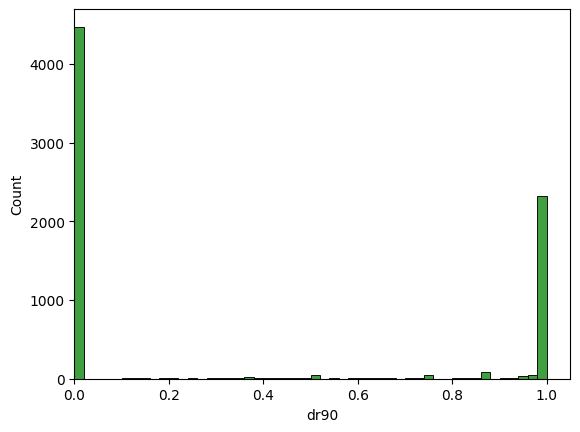

In [30]:
# distribucion del fraude

sns.histplot(df_data["dr90"], bins=50, color="green")
plt.xlim(0, None)   # empieza en 0
plt.show()

Text(0.5, 1.0, 'Distribución del amount de los creditos (log scaled)')

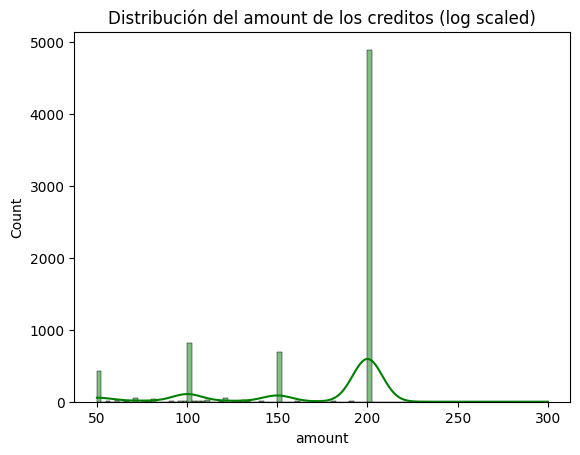

In [31]:


sns.histplot(df_data["amount"], bins=100, kde=True, color="green")
plt.title("Distribución del amount de los creditos (log scaled)")

In [32]:
round(df_data[df_data["amount"].isin([50, 100, 150, 200])].shape[0] / df_data.shape[0], 2)


0.93

In [33]:
lst_cols_trust = [
    'phone_has_whatsapp', 'phone_has_instagram', 'phone_has_aliexpress',
    'phone_has_telegram', 'phone_has_twitter', 'phone_has_weibo',
    'email_has_spotify', 'email_has_linkedin', 'email_has_deliveroo',
    'email_has_pinterest', 'email_has_wordpress', 'email_has_hubspot',
    'email_has_gravatar', 'email_has_atlassian', 'email_has_lastpass',
    'email_has_adobe', 'email_has_freelancer', 'email_has_github',
    'email_has_disney_plus', 'email_has_google', 'email_has_duolingo',
    'has_facebook', 'has_apple', 'has_amazon', 'has_office365'
]

### Data cleaning

In [34]:
lst_col_train = []
# Como los modelos basados en arboels no aceptan variables categoricas mediante Empirical Bayes / Shrinkage daremos un valor de DR a cada banco segun la cantidad de muestras que tenga este.
df_data = shrinkage(df_data, "bank_name")
lst_col_train.append("bank_name_shrinkage")

# Amount
df_data = shrinkage(df_data, "tramo_amount_2")
lst_col_train.append("tramo_amount_2_shrinkage")

# Days
df_data = shrinkage(df_data, "tramo_days")
lst_col_train.append("tramo_days_shrinkage")

# promo_code
lst_col_train.append("promo_code") # variable binaria la añadimos directamente a la lista

# ip_asn_flag
df_data = shrinkage(df_data, "ip_asn_flag")
lst_col_train.append("ip_asn_flag_shrinkage")

# ip_city_flag
df_data = shrinkage(df_data, "ip_city_flag")
lst_col_train.append("ip_city_flag_shrinkage")

# is_apple_realy
lst_col_train.append("is_apple_realy")

# is_nie 
lst_col_train.append("is_nie")

# is_same_name


# digital_presence_score PENDIENTE TRUSTFULL

# tramo_breaches_phone PENDIENTE TRUSTFULL

# tramo_breaches_email PENDIENTE TRUSTFULL

# num_professional_network_tools PENDIENTE TRUSTFULL

# tramo_good_behavioral_apps PENDIENTE TRUSTFULL

# Variable a predecir 



In [35]:
df_count = df_data["fraud"].value_counts().reset_index()
df_count["peso"] = round(df_count["count"] / df_data.shape[0], 2)
df_count

,fraud,count,peso
0,0,4957,0.68
1,1,2309,0.32


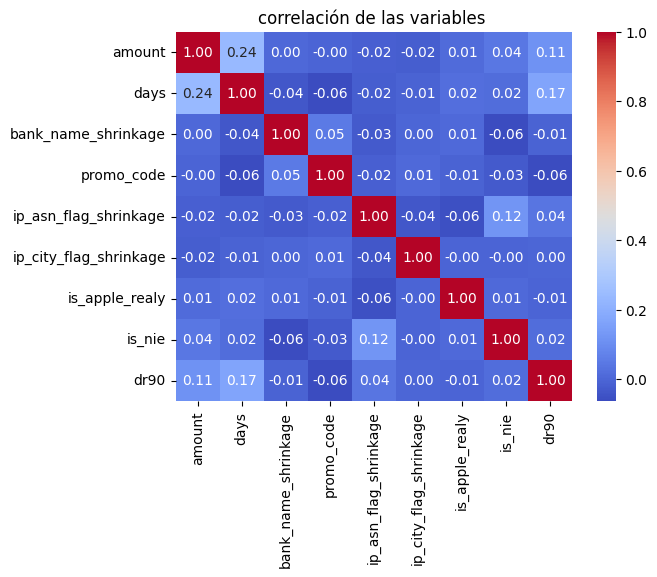

In [36]:
#corr = df_data[lst_final_cols + ["dr90"]].corr()

corr = df_data[["amount", "days", "bank_name_shrinkage", "promo_code", "ip_asn_flag_shrinkage", "ip_city_flag_shrinkage", "is_apple_realy", "is_nie", "dr90"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("correlación de las variables ")
plt.show()

In [37]:
df_filter = df_data[(df_data["year_month_of_creation"]>="2025-07" )&(df_data["year_month_of_creation"]<"2025-09")]

corr = df_filter[
    [
        "amount", "days", "bank_name_shrinkage", "promo_code",
        "ip_asn_flag_shrinkage", "ip_city_flag_shrinkage",
        "is_apple_realy", "is_nie","breaches_count_phone",
        "breaches_count_email", "num_total_plataformas",
        "num_plataformas_comunicacion","num_plataformas_comercial",
        "num_provedores_identidad", "num_professional_network_tools",
        "num_total_good_plataformas",
        "dr90"
    ]
].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("correlación de las variables ")
plt.show()

KeyError: "['num_total_plataformas', 'num_plataformas_comunicacion', 'num_plataformas_comercial', 'num_provedores_identidad', 'num_professional_network_tools', 'num_total_good_plataformas'] not in index"

## Modelo


In [ ]:
print(lst_col_train)

In [39]:
from sklearn.model_selection import train_test_split

def prep_catboost(X, cat_cols):
    X = X.copy()
    for c in cat_cols:
        # Rellena NaN y convierte a string
        X[c] = X[c].astype("object").fillna("__MISSING__").astype(str)
    return X

lst_final_cols = lst_col_train
lst_final_cols =['bank_name_shrinkage', "tramo_amount_2_shrinkage", "days", "promo_code", 'ip_asn_flag_shrinkage', 'ip_city_flag_shrinkage', 'is_apple_realy', 'is_nie']
# lst_cat_cols = ["bank_name", "amount", "days", "promo_code", "ip_asn_flag", "ip_city_flag", "is_apple_realy", "is_nie", ]

X, y = df_data[lst_final_cols], df_data["fraud"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=1
)

In [40]:
from xgboost import XGBRegressor

model = XGBRegressor(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    device="cuda",
    n_estimators=2000,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1,
    early_stopping_rounds=100
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

y_pred = model.predict(X_test)

# seguridad numérica
y_pred = np.clip(y_pred, 0, 1)


best_auc = model.best_score
best_iter = model.best_iteration

print(f"Best AUC (validation): {best_auc:.4f}")
print(f"Best iteration: {best_iter}")

[0]	validation_0-auc:0.60245
[1]	validation_0-auc:0.61362
[2]	validation_0-auc:0.61911
[3]	validation_0-auc:0.62357
[4]	validation_0-auc:0.62018
[5]	validation_0-auc:0.63082
[6]	validation_0-auc:0.63874
[7]	validation_0-auc:0.63990
[8]	validation_0-auc:0.64110
[9]	validation_0-auc:0.63999
[10]	validation_0-auc:0.64170
[11]	validation_0-auc:0.64015
[12]	validation_0-auc:0.64038
[13]	validation_0-auc:0.64076
[14]	validation_0-auc:0.64320
[15]	validation_0-auc:0.64325
[16]	validation_0-auc:0.64368
[17]	validation_0-auc:0.64454
[18]	validation_0-auc:0.64491
[19]	validation_0-auc:0.64413
[20]	validation_0-auc:0.64371
[21]	validation_0-auc:0.64377
[22]	validation_0-auc:0.64384
[23]	validation_0-auc:0.64427
[24]	validation_0-auc:0.64442
[25]	validation_0-auc:0.64383
[26]	validation_0-auc:0.64315
[27]	validation_0-auc:0.64344
[28]	validation_0-auc:0.64283
[29]	validation_0-auc:0.64251
[30]	validation_0-auc:0.64274
[31]	validation_0-auc:0.64389
[32]	validation_0-auc:0.64483
[33]	validation_0-au

c:\Users\Carlos\Documents\Fraud-Model\.venv\Lib\site-packages\xgboost\core.py:774: UserWarning: [16:55:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [ ]:
threshold = np.quantile(y_pred, 0.90)  # top 10% más arriesgados

y_pred_bin = (y_pred >= 0.5).astype(int)

rmse = mean_squared_error(y_test, y_pred_bin)

print(f"RMSE of the base model: {rmse:.3f}")

In [41]:
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)


from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

# columnas
num_cols = ["amount", "days"]
cat_cols = ["bank_name", "promo_code", "ip_asn_flag", "ip_city_flag", "is_apple_realy", "is_nie", "os_family"]

# usa SOLO estas
feature_cols = num_cols + cat_cols

X = df_data[feature_cols].copy()
y = df_data["fraud"].astype(int)


def prep_catboost(X, cat_cols):
    X = X.copy()
    for c in cat_cols:
        X[c] = X[c].astype("object").fillna("__MISSING__").astype(str)
    return X

X = prep_catboost(X, cat_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

model = CatBoostClassifier(
    iterations=2000,
    depth=6,
    learning_rate=0.03,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=50
)

model.fit(
    X_train,
    y_train,
    cat_features=cat_cols,
    eval_set=(X_test, y_test),
    use_best_model=True
)

y_val_proba = model.predict_proba(X_train)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]


C:\Users\Carlos\AppData\Local\Temp\ipykernel_820\598142079.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[c] = X[c].astype("object").fillna("__MISSING__").astype(str)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_820\598142079.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[c] = X[c].astype("object").fillna("__MISSING__").astype(str)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_820\598142079.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_o

0:	test: 0.5796502	best: 0.5796502 (0)	total: 197ms	remaining: 6m 34s
50:	test: 0.6281180	best: 0.6281180 (50)	total: 1.43s	remaining: 54.6s
100:	test: 0.6312884	best: 0.6327830 (75)	total: 2.72s	remaining: 51.1s
150:	test: 0.6326990	best: 0.6346104 (131)	total: 4.14s	remaining: 50.7s
200:	test: 0.6327601	best: 0.6346104 (131)	total: 5.52s	remaining: 49.4s
250:	test: 0.6320565	best: 0.6346104 (131)	total: 7.06s	remaining: 49.2s
300:	test: 0.6298625	best: 0.6346104 (131)	total: 8.65s	remaining: 48.8s
350:	test: 0.6302116	best: 0.6346104 (131)	total: 10.4s	remaining: 48.8s
400:	test: 0.6304756	best: 0.6346104 (131)	total: 12.1s	remaining: 48.4s
450:	test: 0.6288522	best: 0.6346104 (131)	total: 13.8s	remaining: 47.3s
500:	test: 0.6263364	best: 0.6346104 (131)	total: 15.3s	remaining: 45.8s
550:	test: 0.6261444	best: 0.6346104 (131)	total: 16.8s	remaining: 44.3s
600:	test: 0.6262644	best: 0.6346104 (131)	total: 18.4s	remaining: 42.9s
650:	test: 0.6261859	best: 0.6346104 (131)	total: 19.9s	r

In [ ]:
auc_val = roc_auc_score(y_train, y_val_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

print(f"AUC validation: {auc_val:.3f}")
print(f"AUC test: {auc_test:.3f}")

In [ ]:
model.get_feature_importance(prettified=True).head(10)

In [ ]:
thresholds = np.arange(0.1, 0.9, 0.01)

results = []

for t in thresholds:
    y_pred = (y_val_proba >= t).astype(int)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    results.append((t, precision, recall))

results_df = pd.DataFrame(results, columns=["threshold", "precision", "recall"])
results_df[results_df["precision"] >= 0.75].head()

In [ ]:
best_threshold = results_df[results_df["precision"] >= 0.75] \
                    .sort_values("recall", ascending=False) \
                    .iloc[0]["threshold"]

best_threshold

In [ ]:
y_test_pred = (y_test_proba >= best_threshold).astype(int)

print("Confusion matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

In [ ]:
from scipy.stats import ks_2samp

ks = ks_2samp(
    y_test_proba[y_test == 1],
    y_test_proba[y_test == 0]
).statistic

print(f"KS statistic: {ks:.3f}")

In [ ]:
import matplotlib.pyplot as plt

feature_importance = model.get_feature_importance(prettified=True)
print(feature_importance.head(10))

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val)

## Métricas del modelo

In [ ]:


df_data['tramo_dr90'] = pd.qcut(df_data['dr90'], q=6, duplicates='drop')

df_count = df_data['tramo_dr90'].value_counts().reset_index()
df_count

In [ ]:
df_filter = df_data[df_data["tramo_dr90"].astype(str) == "(0.0, 0.98]"]
df_filter = df_filter["dr90"].value_counts().reset_index()

df_filter["cumsum"] = round(df_filter["count"].cumsum() / df_filter["count"].sum(), 4)
df_filter[df_filter["cumsum"]<0.95].head(26)

# Final

In [ ]:
df = pd.read_csv("../data/datos/FULL_69690211b29f8-part1.csv")


# De todas las columnas nos quedamos con aquellas que nos interesan
lst_cols_trust = [
    'phone_value', 'email_value', 'phone_data_breaches_count', 'phone_score',
    'phone_score_cluster','phone_has_whatsapp', 'phone_has_instagram', 
    'phone_has_aliexpress','phone_has_telegram', 'phone_has_twitter', 
    'phone_has_weibo',

     "email_data_breaches_count",'email_score', 'email_score_cluster',
    'email_has_spotify', 'email_has_linkedin', 'email_has_deliveroo',
    'email_has_pinterest', 'email_has_wordpress', 'email_has_hubspot',
    'email_has_gravatar', 'email_has_atlassian', 'email_has_lastpass',
    'email_has_adobe', 'email_has_freelancer', 'email_has_github',
    'email_has_disney_plus', 'email_has_google', 'email_has_duolingo',


    'email_has_facebook','phone_has_facebook', 'email_has_apple',
    'phone_has_apple','email_has_amazon', 'phone_has_amazon',
    'email_has_office365','phone_has_office365'
]



df[lst_cols_trust]